Today was a pretty packed lesson where we introduced a lot of new concepts. In this lesson we looked at how to:

* Use nested loops to remove unwanted characters from multiple columns

* Filter Pandas DataFrames based on multiple conditions using both `.loc[]` and `.query()`

* Create bubble charts using the Seaborn Library

* Style Seaborn charts using the pre-built styles and by modifying Matplotlib parameters

* Use floor division `//` (i.e., integer division) to convert years to decades

* Use Seaborn to superimpose a linear regressions over our data

* Make a judgement if our regression is good or bad based on how well the model fits our data and the r-squared metric

* Run regressions with scikit-learn and calculate the coefficients.



# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [3]:
data = pd.read_csv('cost_revenue_dirty.csv')

# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [4]:
f'{data.shape[0]} rows and {data.shape[1]} columns'

'5391 rows and 6 columns'

In [5]:
data.isna().values.any()  # no missing values

False

In [6]:
data.duplicated().values.any()  # no duplicate rows

False

In [7]:
print(data.columns)
print(data.dtypes)

Index(['Rank', 'Release_Date', 'Movie_Title', 'USD_Production_Budget',
       'USD_Worldwide_Gross', 'USD_Domestic_Gross'],
      dtype='object')
Rank                      int64
Release_Date             object
Movie_Title              object
USD_Production_Budget    object
USD_Worldwide_Gross      object
USD_Domestic_Gross       object
dtype: object


### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [8]:
data[data.columns[3:6]] = data[data.columns[3:6]].replace('[\$,]', '', regex=True).astype(float)
data.dtypes

Rank                       int64
Release_Date              object
Movie_Title               object
USD_Production_Budget    float64
USD_Worldwide_Gross      float64
USD_Domestic_Gross       float64
dtype: object

**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [9]:
data['Release_Date'] = pd.to_datetime(data['Release_Date'])  
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   5391 non-null   int64         
 1   Release_Date           5391 non-null   datetime64[ns]
 2   Movie_Title            5391 non-null   object        
 3   USD_Production_Budget  5391 non-null   float64       
 4   USD_Worldwide_Gross    5391 non-null   float64       
 5   USD_Domestic_Gross     5391 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 252.8+ KB


### Descriptive Statistics

**Challenge**: 

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [10]:
# Average production budget
'{:,.2f}'.format(data['USD_Production_Budget'].values.mean())
# 31 million!

'31,113,737.58'

In [11]:
# Average WW gross revenue
'{:,.2f}'.format(data['USD_Worldwide_Gross'].values.mean())
# 89 million!

'88,855,421.96'

In [12]:
# Minimum revenue
f"WW: {data['USD_Worldwide_Gross'].values.min()}  ||  US-only: {data['USD_Domestic_Gross'].values.min()}"
# no revenue...

'WW: 0.0  ||  US-only: 0.0'

In [13]:
# Bottom 25% of films generally lose money
x = data['USD_Worldwide_Gross'].quantile(.25)
bottom_25p = data.loc[data['USD_Worldwide_Gross'] < x, ].copy(deep=True)
bottom_25p['Net_Revenue'] = bottom_25p['USD_Worldwide_Gross'] - bottom_25p['USD_Production_Budget']
bottom_25p['Net_Revenue'].describe()

count          1,348.00
mean      -5,438,277.00
std       10,936,195.76
min     -175,000,000.00
25%       -6,728,266.50
50%       -1,996,101.50
75%         -300,000.00
max        3,559,226.00
Name: Net_Revenue, dtype: float64

In [14]:
# highest production budget and WW gross revenue
print(f'Highest Production Budget: {data["USD_Production_Budget"].max():,.2f}')
print(f'Highest WW Gross Revenue: {data["USD_Worldwide_Gross"].max():,.2f}')

Highest Production Budget: 425,000,000.00
Highest WW Gross Revenue: 2,783,918,982.00


In [15]:
low_b = data[data["USD_Production_Budget"] == data["USD_Production_Budget"].min()]
high_b = data[data["USD_Production_Budget"] == data["USD_Production_Budget"].max()]
print(f'Lowest budget WW revenue: {low_b["USD_Worldwide_Gross"]}')
print(f'Highest budget WW revenue: {high_b["USD_Worldwide_Gross"]}')

Lowest budget WW revenue: 2427   181,041.00
Name: USD_Worldwide_Gross, dtype: float64
Highest budget WW revenue: 3529   2,783,918,982.00
Name: USD_Worldwide_Gross, dtype: float64


# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [16]:
zero_us_rev = data.loc[data['USD_Domestic_Gross'] == 0].copy()  # 512 films grossed $0 in the US
print(zero_us_rev.shape)
zero_us_rev.sort_values('USD_Production_Budget', ascending=False).head()


(512, 6)


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,"175,000,000.00",0.00,0.00
5387,126,2018-12-18,Aquaman,"160,000,000.00",0.00,0.00
5384,321,2018-09-03,A Wrinkle in Time,"103,000,000.00",0.00,0.00
5385,366,2018-10-08,Amusement Park,"100,000,000.00",0.00,0.00
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla","80,000,000.00","4,547,660.00",0.00


**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [17]:
zero_ww_rev = data.loc[data['USD_Worldwide_Gross'] == 0].copy()  # 357 films grossed $0 worldwide
print(zero_ww_rev.shape)
zero_ww_rev.sort_values('USD_Production_Budget', ascending=False).head()

(357, 6)


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,"175,000,000.00",0.00,0.00
5387,126,2018-12-18,Aquaman,"160,000,000.00",0.00,0.00
5384,321,2018-09-03,A Wrinkle in Time,"103,000,000.00",0.00,0.00
5385,366,2018-10-08,Amusement Park,"100,000,000.00",0.00,0.00
5058,880,2015-11-12,The Ridiculous 6,"60,000,000.00",0.00,0.00


### Filtering on Multiple Conditions

In [18]:
international_releases = data.loc[(data['USD_Domestic_Gross'] == 0) & 
                                  (data['USD_Worldwide_Gross'] != 0)]
international_releases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 71 to 5374
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   155 non-null    int64         
 1   Release_Date           155 non-null    datetime64[ns]
 2   Movie_Title            155 non-null    object        
 3   USD_Production_Budget  155 non-null    float64       
 4   USD_Worldwide_Gross    155 non-null    float64       
 5   USD_Domestic_Gross     155 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 8.5+ KB


**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

Hint: This time you'll have to use the `and` keyword.

In [19]:
international_releases = data.query('USD_Domestic_Gross == 0 and USD_Worldwide_Gross > 0')
international_releases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 71 to 5374
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   155 non-null    int64         
 1   Release_Date           155 non-null    datetime64[ns]
 2   Movie_Title            155 non-null    object        
 3   USD_Production_Budget  155 non-null    float64       
 4   USD_Worldwide_Gross    155 non-null    float64       
 5   USD_Domestic_Gross     155 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 8.5+ KB


### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [20]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

unreleased = data.loc[data['Release_Date'] > scrape_date]
unreleased.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 5384 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   7 non-null      int64         
 1   Release_Date           7 non-null      datetime64[ns]
 2   Movie_Title            7 non-null      object        
 3   USD_Production_Budget  7 non-null      float64       
 4   USD_Worldwide_Gross    7 non-null      float64       
 5   USD_Domestic_Gross     7 non-null      float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 392.0+ bytes


In [21]:
data_clean = data.loc[data['Release_Date'] < scrape_date].copy()

### Films that Lost Money

**Challenge**: 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [22]:
data_clean['Net_Revenue'] = data_clean['USD_Worldwide_Gross'] - data_clean['USD_Production_Budget']
data_clean.loc[data_clean['Net_Revenue'] < 0, 'Loss_Flag'] = True
len(data_clean.loc[data_clean['Loss_Flag'] == True]) / len(data_clean)

0.37277117384843983

# Seaborn for Data Viz: Bubble Charts

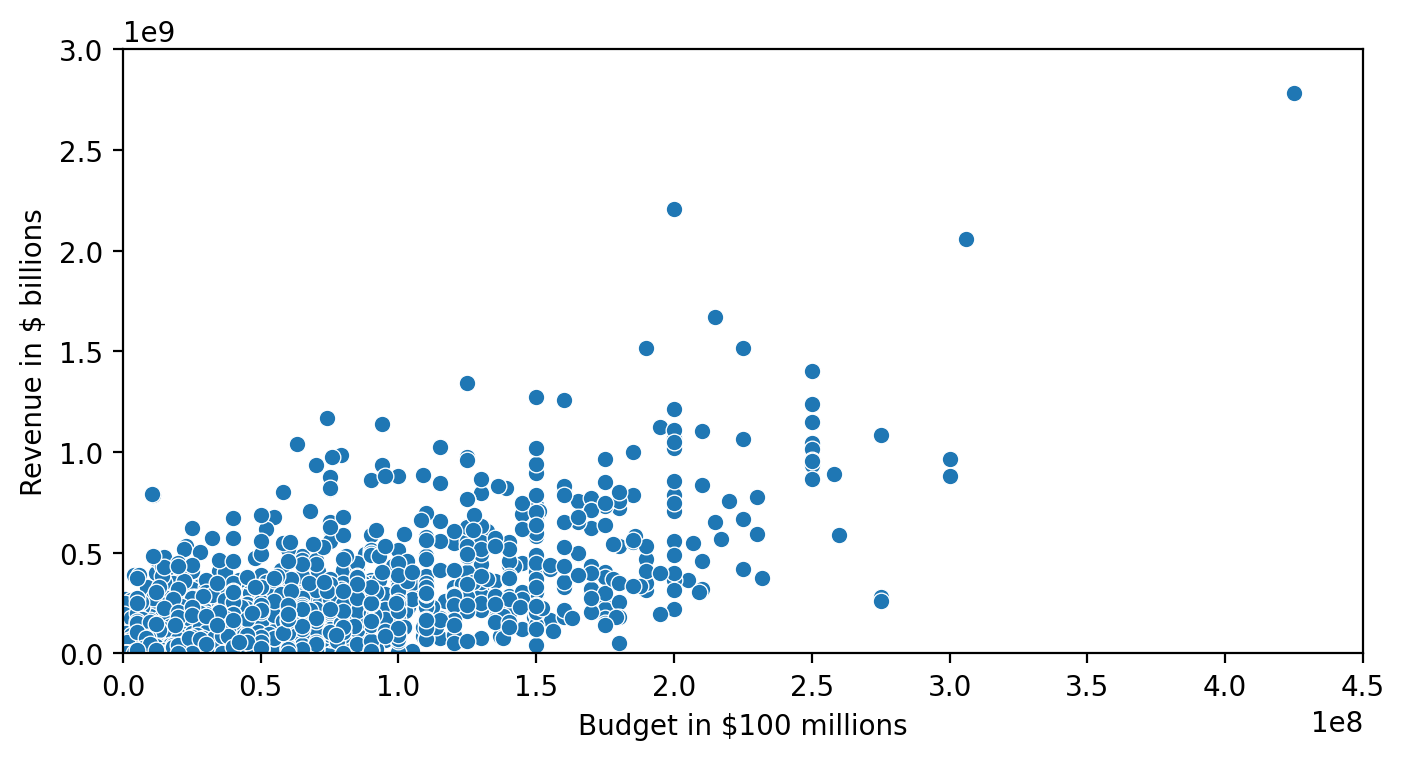

In [23]:
plt.figure(figsize=(8,4), dpi=200)
ax = sns.scatterplot(data=data_clean,
                     x='USD_Production_Budget', 
                     y='USD_Worldwide_Gross')
ax.set(ylim=(0, 3000000000),
       xlim=(0, 450000000),
       ylabel='Revenue in $ billions',
       xlabel='Budget in $100 millions')
plt.show()

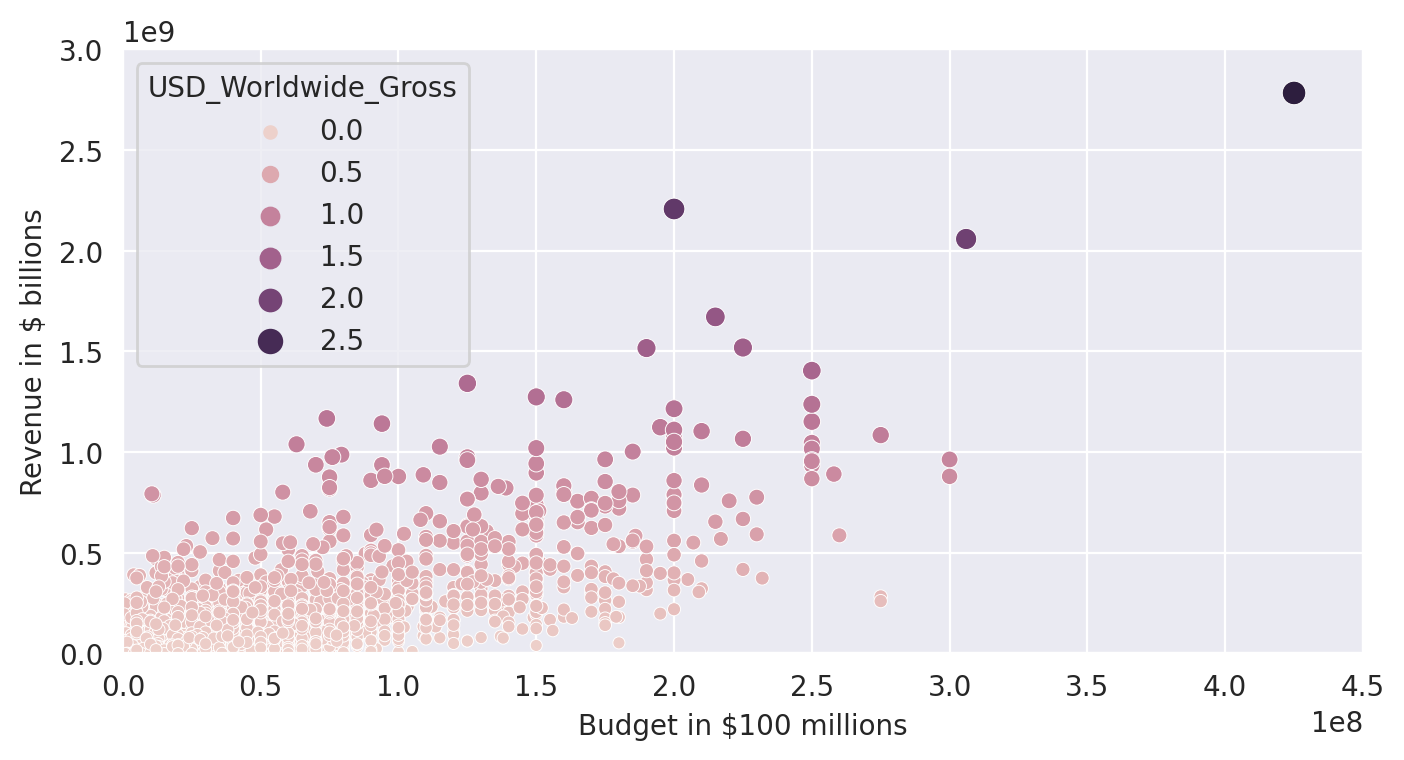

In [24]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=data_clean,
                      x='USD_Production_Budget', 
                      y='USD_Worldwide_Gross',
                      hue='USD_Worldwide_Gross', # color
                      size='USD_Worldwide_Gross') # dot size
  ax.set(ylim=(0, 3000000000),
        xlim=(0, 450000000),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $100 millions')

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>



In [25]:
data_clean

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Net_Revenue,Loss_Flag
0,5293,1915-08-02,The Birth of a Nation,"110,000.00","11,000,000.00","10,000,000.00","10,890,000.00",NaN
1,5140,1916-05-09,Intolerance,"385,907.00",0.00,0.00,"-385,907.00",True
2,5230,1916-12-24,"20,000 Leagues Under the Sea","200,000.00","8,000,000.00","8,000,000.00","7,800,000.00",NaN
3,5299,1920-09-17,Over the Hill to the Poorhouse,"100,000.00","3,000,000.00","3,000,000.00","2,900,000.00",NaN
4,5222,1925-01-01,The Big Parade,"245,000.00","22,000,000.00","11,000,000.00","21,755,000.00",NaN
...,...,...,...,...,...,...,...,...
5379,1295,2017-10-02,John Wick: Chapter Two,"40,000,000.00","166,893,990.00","92,029,184.00","126,893,990.00",NaN
5380,70,2017-10-03,Kong: Skull Island,"185,000,000.00","561,137,727.00","168,052,812.00","376,137,727.00",NaN
5381,94,2017-12-05,King Arthur: Legend of the Sword,"175,000,000.00","140,012,608.00","39,175,066.00","-34,987,392.00",True
5382,1254,2017-12-05,Snatched,"42,000,000.00","57,850,343.00","45,850,343.00","15,850,343.00",NaN


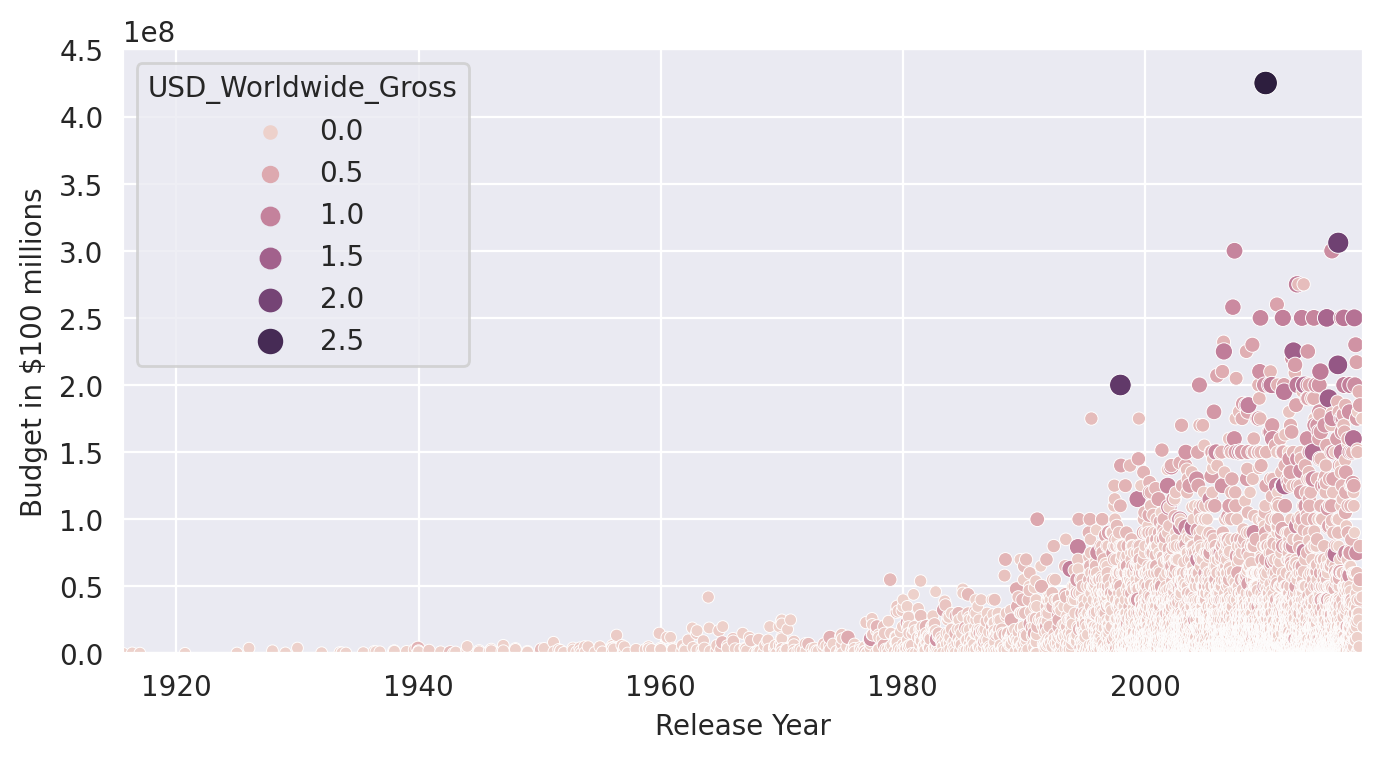

In [26]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=data_clean,
                      x='Release_Date', 
                      y='USD_Production_Budget',
                      hue='USD_Worldwide_Gross', # color
                      size='USD_Worldwide_Gross') # dot size
  ax.set(ylim=(0, 450000000),
        xlim=(data_clean.Release_Date.min(), data_clean.Release_Date.max()),
        ylabel='Budget in $100 millions',
        xlabel='Release Year')

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release. 

<img src=https://i.imgur.com/0VEfagw.png width=650> 

Here's how: 
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [41]:
data_clean['Decade'] = data['Release_Date'].dt.year // 10 * 10
data_clean

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Net_Revenue,Loss_Flag,Decade
0,5293,1915-08-02,The Birth of a Nation,"110,000.00","11,000,000.00","10,000,000.00","10,890,000.00",NaN,1910
1,5140,1916-05-09,Intolerance,"385,907.00",0.00,0.00,"-385,907.00",True,1910
2,5230,1916-12-24,"20,000 Leagues Under the Sea","200,000.00","8,000,000.00","8,000,000.00","7,800,000.00",NaN,1910
3,5299,1920-09-17,Over the Hill to the Poorhouse,"100,000.00","3,000,000.00","3,000,000.00","2,900,000.00",NaN,1920
4,5222,1925-01-01,The Big Parade,"245,000.00","22,000,000.00","11,000,000.00","21,755,000.00",NaN,1920
...,...,...,...,...,...,...,...,...,...
5379,1295,2017-10-02,John Wick: Chapter Two,"40,000,000.00","166,893,990.00","92,029,184.00","126,893,990.00",NaN,2010
5380,70,2017-10-03,Kong: Skull Island,"185,000,000.00","561,137,727.00","168,052,812.00","376,137,727.00",NaN,2010
5381,94,2017-12-05,King Arthur: Legend of the Sword,"175,000,000.00","140,012,608.00","39,175,066.00","-34,987,392.00",True,2010
5382,1254,2017-12-05,Snatched,"42,000,000.00","57,850,343.00","45,850,343.00","15,850,343.00",NaN,2010


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [53]:
old_films = data_clean.loc[data_clean['Decade'] < 1970].reset_index()
print(old_films['Release_Date'].max())
new_films = data_clean.loc[data_clean['Decade'] > 1960].reset_index()
print(new_films['Release_Date'].min())

1969-12-19 00:00:00
1970-01-01 00:00:00


In [54]:
old_films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  153 non-null    int64         
 1   Rank                   153 non-null    int64         
 2   Release_Date           153 non-null    datetime64[ns]
 3   Movie_Title            153 non-null    object        
 4   USD_Production_Budget  153 non-null    float64       
 5   USD_Worldwide_Gross    153 non-null    float64       
 6   USD_Domestic_Gross     153 non-null    float64       
 7   Net_Revenue            153 non-null    float64       
 8   Loss_Flag              25 non-null     object        
 9   Decade                 153 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 12.1+ KB


In [55]:
new_films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231 entries, 0 to 5230
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  5231 non-null   int64         
 1   Rank                   5231 non-null   int64         
 2   Release_Date           5231 non-null   datetime64[ns]
 3   Movie_Title            5231 non-null   object        
 4   USD_Production_Budget  5231 non-null   float64       
 5   USD_Worldwide_Gross    5231 non-null   float64       
 6   USD_Domestic_Gross     5231 non-null   float64       
 7   Net_Revenue            5231 non-null   float64       
 8   Loss_Flag              1982 non-null   object        
 9   Decade                 5231 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 408.8+ KB


# Seaborn Regression Plots

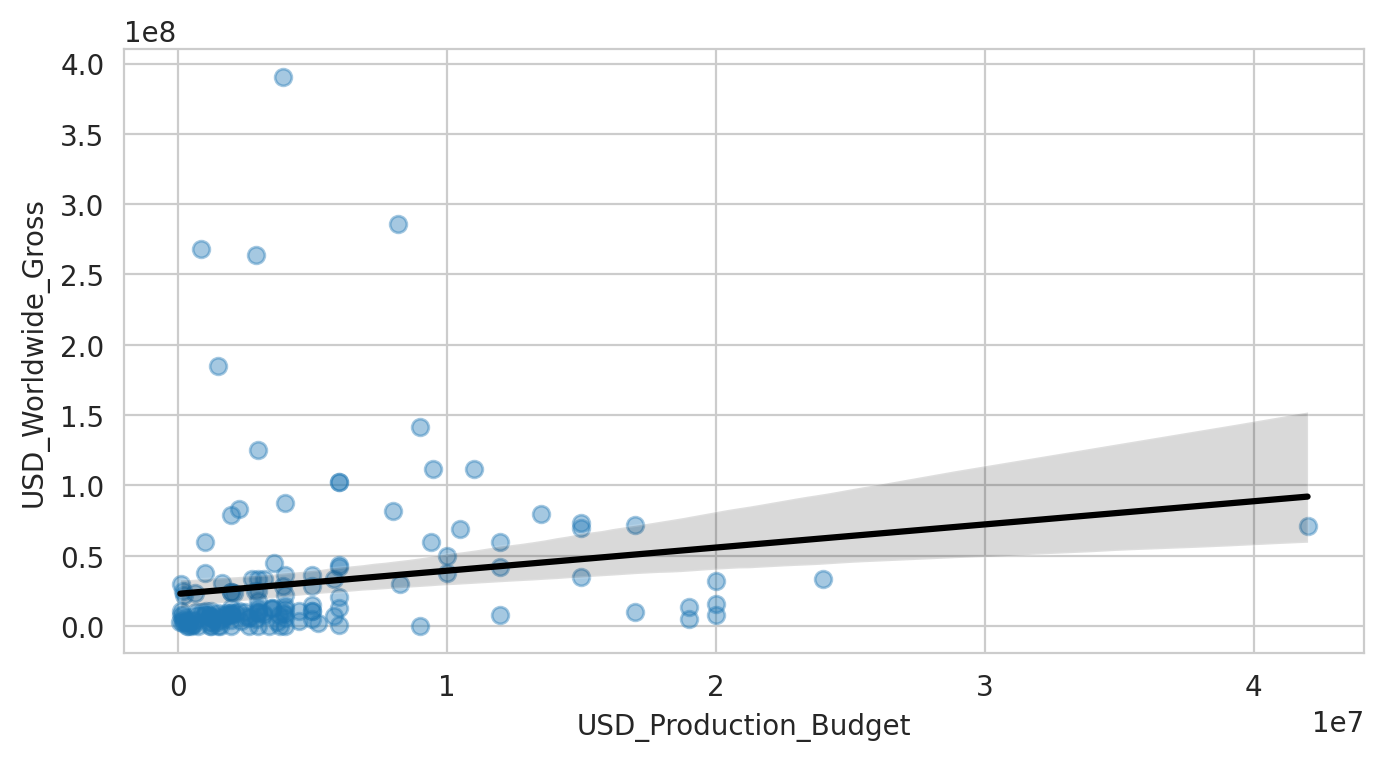

In [58]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("whitegrid"):
  sns.regplot(data=old_films,
              x='USD_Production_Budget',
              y='USD_Worldwide_Gross',
              scatter_kws = {'alpha': 0.4},
              line_kws = {'color': 'black'})

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

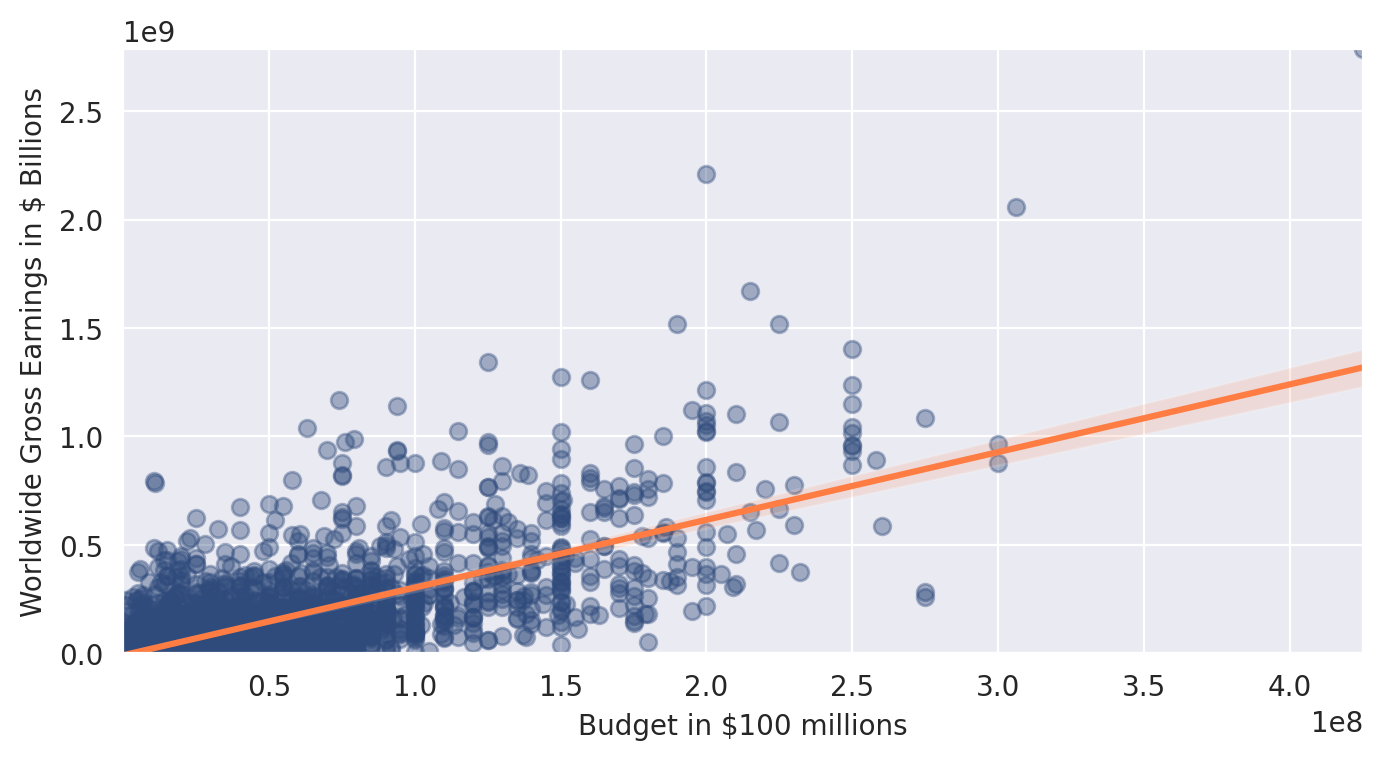

In [63]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("darkgrid"):
  ax = sns.regplot(data=new_films,
                   x='USD_Production_Budget',
                   y='USD_Worldwide_Gross',
                   scatter_kws = {'color': '#2f4b7c', 'alpha': 0.4},
                   line_kws = {'color': '#ff7c43'})

  ax.set(ylim=(0, max(data['USD_Worldwide_Gross'])),
        xlim=(data_clean['USD_Production_Budget'].min(), data_clean['USD_Production_Budget'].max()),
        ylabel='Worldwide Gross Earnings in $ Billions',
        xlabel='Budget in $100 millions')

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [65]:
regression = LinearRegression()  # Create an object

In [67]:
# Explanatory Variable(s) or Feature(s)
X = pd.DataFrame(new_films, columns=['USD_Production_Budget'])  # capital X
 
# Response Variable or Target
y = pd.DataFrame(new_films, columns=['USD_Worldwide_Gross'])  # lower y

# NOTE: LinearRegression object wants DATAFRAMES, not Series. Hence the new dfs above for X and y

# Find the best-fit line
regression.fit(X, y)

LinearRegression()

In [68]:
# Intercept
regression.intercept_

array([-8650768.00661027])

In [70]:
# Coefficients
regression.coef_

array([[3.12259592]])

In [72]:
# R-squared
regression.score(X, y)

0.5577032617720403

**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [73]:
old_films_model = LinearRegression()

In [74]:
X = pd.DataFrame(old_films, columns=['USD_Production_Budget'])
y = pd.DataFrame(old_films, columns=['USD_Worldwide_Gross'])
old_films_model.fit(X, y)

LinearRegression()

In [80]:
print(f"Old Films Model R-Squared: {old_films_model.score(X, y)}")
print(f"Old Films Model Intercept: {old_films_model.intercept_} and coefficients: {old_films_model.coef_}")

Old Films Model R-Squared: 0.02937258620576877
Old Films Model Intercept: [22821538.63508039] and coefficients: [[1.64771314]]


# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [84]:
budget = 350000000
revenue_estimate = regression.intercept_[0] + regression.coef_[0,0]*budget
revenue_estimate = round(revenue_estimate, -6)
revenue_estimate

1084000000.0

In [92]:
print(f'The estimated revenue for a $350 M film is around ${revenue_estimate:,.0f}.')

The estimated revenue for a $350 M film is around $1,084,000,000.
